# Machine learning
## Preprocessing
We need to deal with nans and one hot encode the categorical variables.

In [283]:
# import neccesary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator # for type hinting

In [284]:
data = pd.read_csv("cleared_data.csv") # name cleared_data might be misleading because i didnt remove nans and one-hot-encoded the categorical variables
data = data.apply(lambda column: column.astype("category") if column.dtype == "object" else column)

RANDOM_SEED = 34
OVERSAPLING_NUM = 1000

Before removing nans i want to divide the dataset into `test_data` and `train_data`. \
As said in `analysis.ipynb` data is **EXTREMELY** unbalanced, so we want to make sure that the `test_data` accuratly represents the data distribution (we want to avoid the situation where there is none or only a handful of `high_credit_risk` observations)

### Train Test Split

In [285]:
# select non nan data
non_data = data.dropna()

# select 50 high credit resk observations for test data and 500 low risk observations
test_data = non_data[non_data["credit_risk"] == 1].sample(50, random_state=RANDOM_SEED)
test_data = pd.concat([test_data, non_data[non_data["credit_risk"] == 0].sample(500, random_state=RANDOM_SEED)])

training_data = data.drop(index = test_data.index)

# great so now we have non Nan 550 test set and 9450 training set

### Nan's in training set
mindless deleting nans would mean loss of a lot of valuable information *(especially when information is precious for high risk observations)*, so instead let's replace Nan's with propable values

In [286]:
def deal_with_nans(data: pd.DataFrame) -> pd.DataFrame:
    for column in data.columns:
        if data[column].dtype == "category" or data[column].dtype == "object":
            data.loc[:, column] = data.loc[:, column].ffill()# use this instead of fillna(data[column].mode()) because for some ungodly reason it doesnt delete all the Nan's
        elif data[column].dtype == np.int64:
            data.loc[:, (column)] = data.loc[:, (column)].fillna(data[column].median())# I use this strange indexing method so that pandas wont torture me with endless warnings
        else:
            data.loc[:, (column)] = data.loc[:, (column)].fillna(data[column].mean())
    return data

training_data = pd.concat([deal_with_nans(training_data[training_data["credit_risk"] == 1]), deal_with_nans(training_data[training_data["credit_risk"] == 0])])
del training_data["Unnamed: 0"]
del test_data["Unnamed: 0"]

### Dealing with unbalanced target variable
We need to crteate synthetic data in order to mitigate the negatives of training with unbalanced dataset. And then oversample it in `training_data`.

In [287]:
generated_data = pd.DataFrame()
for column in training_data.columns:
    generated_data[column] = training_data[training_data["credit_risk"] == 1][column].sample(OVERSAPLING_NUM,
                                                                                             replace = True,
                                                                                             ignore_index=True,
                                                                                             random_state=RANDOM_SEED)

generated_data.head()

,age,income,children,credit_history,overdue_payments,active_loans,years_in_job,employment_type,owns_property,assets_value,other_loans,education,city,marital_status,credit_risk
0,24,29019.0,1,brak historii,1.107981,6,14,stała,1.000000,69812.000000,1,1,1,kawaler/panna,1
1,36,21491.0,0,dobra historia,2.000000,1,2,stała,1.000000,65182.000000,1,0,2,żonaty/zamężna,1
2,31,40000.0,1,dobra historia,1.000000,6,14,stała,0.588235,67790.000000,1,1,1,kawaler/panna,1
3,43,22152.0,0,brak historii,1.107981,1,13,określona,0.588235,80218.135678,0,1,0,żonaty/zamężna,1
4,37,40000.0,2,dobra historia,2.000000,2,2,stała,0.000000,46504.000000,1,1,2,żonaty/zamężna,1


In [288]:
training_data = pd.concat([training_data, generated_data]) ## add generated data to training set

### one hot encoding categorical non-ordinal features

In [289]:
cat_columns = training_data.select_dtypes(include=["category", "object"]).columns
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(training_data[cat_columns])

def one_hot_encode(data: pd.DataFrame) -> pd.DataFrame:
    one_hot = encoder.transform(data[cat_columns].to_numpy())
    one_hot = pd.DataFrame(one_hot, columns=encoder.get_feature_names_out())

    data = data.join(one_hot)
    data = data.drop(cat_columns, axis=1)
    return data

In [290]:
training_data = one_hot_encode(training_data)
test_data = one_hot_encode(test_data)

/home/kuba/Dokumenty/projekty/python/bootcamp/bootcamp_venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/kuba/Dokumenty/projekty/python/bootcamp/bootcamp_venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [291]:
training_target = training_data["credit_risk"]
del training_data["credit_risk"]

test_target = test_data["credit_risk"]
del test_data["credit_risk"]

## Machine Learning model #1 - Decision Tree Classifier

Let's now use Decision tree to try to acurately predict `credit_risk`

In [292]:
tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=5, random_state=RANDOM_SEED)
tree_model.fit(training_data, training_target)
display(Markdown(f" * Model accuracy after validating: {round(tree_model.score(test_data, test_target), 4)}"))
display(Markdown(f" * high risk rate in `test_target`: {round(sum(test_target) / len(test_target), 4)}"))

 * Model accuracy after validating: 0.9709

 * high risk rate in `test_target`: 0.0909

In [293]:
def evaluate_model(model:BaseEstimator,
                   data:pd.DataFrame,
                   expected:pd.Series
                   ) -> pd.DataFrame:
    
    evaluated = model.predict(data)
    confusion_matrix = pd.DataFrame(np.zeros((2,2)),
                                    index=["Predicted Positive", "Predicted Negative"],
                                    columns=["True Positive", "True Negative"])
    
    for ev, ex in zip(evaluated, expected):
        if ev and ex:
            confusion_matrix.loc["Predicted Positive", "True Positive"] += 1
        elif not ev and not ex:
            confusion_matrix.loc["Predicted Negative", "True Negative"] += 1
        elif ev and not ex:
            confusion_matrix.loc["Predicted Positive", "True Negative"] += 1
        elif not ev and ex:
            confusion_matrix.loc["Predicted Negative", "True Positive"] += 1

    display(Markdown(confusion_matrix.to_markdown()))

    #con_sum = len(evaluated)
    acc = (confusion_matrix.loc["Predicted Positive", "True Positive"] + confusion_matrix.loc["Predicted Negative", "True Negative"])/ len(evaluated)
    rec = confusion_matrix.loc["Predicted Positive", "True Positive"] / (confusion_matrix.loc["Predicted Positive", "True Positive"] + confusion_matrix.loc[ "Predicted Negative", "True Positive"])
    prec = confusion_matrix.loc["Predicted Positive", "True Positive"] / (confusion_matrix.loc["Predicted Positive", "True Positive"] + confusion_matrix.loc[ "Predicted Positive", "True Negative"])
    display(Markdown("### Relevant metrics"))
    display(Markdown(f'Accuracy: {round(acc, 4)}'))
    display(Markdown(f'Recall: {round(rec, 4)}'))
    display(Markdown(f'Precision: {round(prec, 4)}'))
    return confusion_matrix

confusion_matrix = evaluate_model(tree_model, test_data, test_target)

|                    |   True Positive |   True Negative |
|:-------------------|----------------:|----------------:|
| Predicted Positive |              34 |               0 |
| Predicted Negative |              16 |             500 |

### Relevant metrics

Accuracy: 0.9709

Recall: 0.68

Precision: 1.0

So our model make a bad decision 1/4 times when `credit_risk` == 1

Now, lets visualize out tree

In [294]:
fig, ax = plt.subplots(1,1,figsize=(30,30), dpi=300)
#fig.suptitle("Tree model visualized")
plot_tree(tree_model, ax = ax, feature_names=training_data.columns, class_names=['0', "1"], filled=True, fontsize=20)
ax.title.set_text("Tree Classifier Visualized")
ax.title.set_fontsize(64.)
plt.show()

### Now lets show feature importance in deciding whether a person has high or low credit risk

In [295]:
feature_importance = pd.DataFrame(tree_model.feature_importances_, columns=["Feature Importance"], index=training_data.columns)
display(Markdown( feature_importance.sort_values(by="Feature Importance", ascending=False).to_markdown() ))

|                                          |   Feature Importance |
|:-----------------------------------------|---------------------:|
| active_loans                             |            0.480591  |
| overdue_payments                         |            0.34954   |
| income                                   |            0.111093  |
| assets_value                             |            0.0587755 |
| children                                 |            0         |
| age                                      |            0         |
| years_in_job                             |            0         |
| owns_property                            |            0         |
| other_loans                              |            0         |
| education                                |            0         |
| city                                     |            0         |
| credit_history_brak historii             |            0         |
| credit_history_dobra historia            |            0         |
| employment_type_brak                     |            0         |
| employment_type_określona                |            0         |
| employment_type_samozatrudnienie         |            0         |
| employment_type_stała                    |            0         |
| marital_status_kawaler/panna             |            0         |
| marital_status_rozwiedziony/rozwiedziona |            0         |
| marital_status_żonaty/zamężna            |            0         |

As you can see features indentified in `analysis.ipynb` as the most likely to have a relation to `credit_risk` gave th emost information to our model, *yay*!

Now, visualize the feature importance

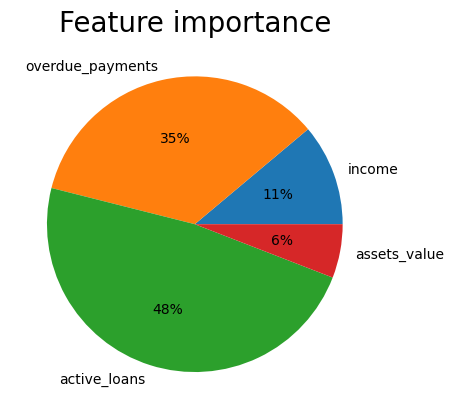

In [296]:
#columns = feature_importance[feature_importance["Feature Importance"] > 0]
non_zero_f_imp = feature_importance[feature_importance["Feature Importance"] > 0.01]
plt.pie(non_zero_f_imp["Feature Importance"],
        labels=non_zero_f_imp.index,
        autopct='%.0f%%')

plt.title("Feature importance", fontdict={"fontsize":20})
plt.show()


### Experiment with linear regression
Perhaps, we could use only `active_loans`, `overdue_payments` and `income` to accuratily predict `credit_risk`?

In [297]:
experiment_train = training_data[["active_loans", "overdue_payments", "income"]]
experiment_test = test_data[["active_loans", "overdue_payments", "income"]]

logres_model = LogisticRegression(max_iter=300)
logres_model.fit(experiment_train, training_target)
display(Markdown(f"Logistic regression model accuracy: {round(logres_model.score(experiment_test, test_target), 3)}"))
evaluate_model(logres_model, experiment_test, test_target)

Logistic regression model accuracy: 0.922

|                    |   True Positive |   True Negative |
|:-------------------|----------------:|----------------:|
| Predicted Positive |              17 |              10 |
| Predicted Negative |              33 |             490 |

### Relevant metrics

Accuracy: 0.9218

Recall: 0.34

Precision: 0.6296

,True Positive,True Negative
Predicted Positive,17.0,10.0
Predicted Negative,33.0,490.0


Well sadly this model does not perform well, maybe if we tweaked with hyperparameter we would get better results.

## Summary

We built Decision Tree model that predicts credit risk, we evaluated it and showed the most important features in predicting the target variable